In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from utility_functions import report
# sklearn modules
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
echo_genres = pd.read_csv('//Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/clean_datasets/echo_genres.csv')
echo_genres.set_index('track_id', inplace=True)
echo_genres.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
track_id,,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,Pop
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop


In [4]:
echo_genres.genre_top.value_counts()

Rock                   3892
Electronic             2170
Hip-Hop                 910
Folk                    874
Old-Time / Historic     357
Pop                     346
Classical               265
Jazz                    241
International           133
Instrumental             84
Blues                    66
Experimental             17
Name: genre_top, dtype: int64

# Multiclass classification : 8 genres

In [13]:
genres_subset = ['Rock','Electronic','Hip-Hop','Folk','Old-Time / Historic','Pop',
          'Classical','Jazz']
# generating dataset for multiclass classification task
echo_gen = echo_genres[echo_genres['genre_top'].isin(genres_subset)]
echo_gen.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
track_id,,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,Pop
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop


In [14]:
echo_gen.shape

(9055, 9)

In [15]:
# encoding labels
le = preprocessing.LabelEncoder()
echo_gen['genre_top'] = le.fit_transform(echo_gen['genre_top'])

In [17]:
print('Legend:\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\n7: Rock')
echo_gen.genre_top.value_counts()

Legend:
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock


7    3892
1    2170
3     910
2     874
5     357
6     346
0     265
4     241
Name: genre_top, dtype: int64

In [18]:
# detach target col
genre_labels = echo_gen['genre_top']
echo_gen.drop('genre_top', axis=1, inplace=True)

In [19]:
# shuffle and split into development set and internal test set
X_develop, X_test, y_develop, y_test = train_test_split(
echo_gen, genre_labels, test_size=0.30, random_state=42)

In [20]:
# check partitions
print(f"____Legend_____\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\n7: Rock'\n\nDevelopment set:\
\n{y_develop.value_counts()}\n\nInternal Test:\n{y_test.value_counts()}")

____Legend_____
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock'

Development set:
7    2728
1    1518
3     643
2     592
5     271
6     239
0     179
4     168
Name: genre_top, dtype: int64

Internal Test:
7    1164
1     652
2     282
3     267
6     107
0      86
5      86
4      73
Name: genre_top, dtype: int64


In [21]:
# normalize datas
scaler = StandardScaler(copy=False)
X_develop = scaler.fit_transform(X_develop)
X_test = scaler.transform(X_test)

# PCA Multiclass

In [22]:
pca = PCA(n_components=2)
pca.fit(X_develop)
X_pca = pca.transform(X_develop)
X_testPCA = pca.transform(X_test)

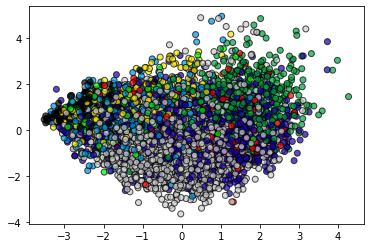

In [36]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_develop, cmap=plt.cm.nipy_spectral, edgecolor='k', alpha=0.7)
plt.show()

Few classes seem to be concentrated in a given area(i.e. grey, green). Others are not well separated,
 probabily due to the high number of classes (8) which might share some similarities in the audio feature
 values.

## Model Selection

## Decision Tree - Multiclass genre classification

In [31]:
# 10 fold cross validation - grid search
param_grid = {
               "max_depth": [3,4,5,6,7,8,9,10,12,15,20, None],
               "min_samples_leaf": [25,45,75,150,250,300,400,500,600,None],
               "criterion": ["gini", "entropy"]
             }
# model
dtc = DecisionTreeClassifier()
stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
random_search = GridSearchCV(dtc, cv =stratified_cv , param_grid=param_grid, n_jobs=2, verbose=True)

random_search.fit(X_develop, y_develop)
dtc=random_search.best_estimator_
report(random_search.cv_results_, n_top=10)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits
Model with rank: 1
Mean validation score: 0.625 (std: 0.013)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 25}

Model with rank: 2
Mean validation score: 0.623 (std: 0.017)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 45}

Model with rank: 3
Mean validation score: 0.623 (std: 0.015)
Parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 45}

Model with rank: 4
Mean validation score: 0.623 (std: 0.009)
Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 25}

Model with rank: 5
Mean validation score: 0.622 (std: 0.013)
Parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 25}

Model with rank: 6
Mean validation score: 0.622 (std: 0.014)
Parameters: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 45}

Model with rank: 7
Mean validation score: 0.622 (std: 0.008)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 

## Retrain on full development set and prediction

In [37]:
dtc = DecisionTreeClassifier(criterion= 'gini',max_depth=7, min_samples_leaf= 25)
dtc.fit(X_develop,y_develop)

y_pred_dtc = dtc.predict(X_test)

print('Legend:\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\n7: Rock')
print('Accuracy %s' % accuracy_score(y_test, y_pred_dtc))
print('F1-score %s' % f1_score(y_test, y_pred_dtc, average=None))
print(classification_report(y_test, y_pred_dtc))

Legend:
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock
Accuracy 0.6209054103790946
F1-score [0.61538462 0.57347101 0.40595903 0.59137577 0.         0.75
 0.         0.72617247]
              precision    recall  f1-score   support

           0       0.77      0.51      0.62        86
           1       0.59      0.55      0.57       652
           2       0.43      0.39      0.41       282
           3       0.65      0.54      0.59       267
           4       0.00      0.00      0.00        73
           5       0.70      0.80      0.75        86
           6       0.00      0.00      0.00       107
           7       0.65      0.82      0.73      1164

    accuracy                           0.62      2717
   macro avg       0.48      0.45      0.46      2717
weighted avg       0.58      0.62      0.59      2717

